In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../")
from utils import display_model

In [2]:
data_dir = "../../data/20231009_LCLS_Injector/"

vanilla_files = [
    "vanilla_optimization_9d_1.yml",
    "vanilla_optimization_9d_2.yml",
    "vanilla_optimization_9d_3.yml",
    "vanilla_optimization_9d_4.yml",
]

nn_files = [
    # "nn_optimization_9d_1.yml",
    # "nn_optimization_9d_2.yml",
    "nn_optimization_9d_3_low_reg_cal.yml",
    "nn_optimization_9d_4_fixed_offset.yml",
]

files = vanilla_files + nn_files

In [3]:
def eval_beamsize(input_dict):
    pass

In [4]:
vanilla_xs = []
for file in vanilla_files:
    with open(data_dir + file) as f:
        X = Xopt.from_yaml(f)
    vanilla_xs.append(X)

nn_xs = []
for file in nn_files:
    with open(data_dir + file) as f:
        print(file)
        X = Xopt.from_yaml(f)
    nn_xs.append(X)

xs = vanilla_xs + nn_xs

nn_optimization_9d_3_low_reg_cal.yml
nn_optimization_9d_4_fixed_offset.yml


## Load NN Prior Model

In [5]:
objective_scale = 1e-3

In [6]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        sigma_xy = torch.sqrt(sigma_x ** 2 + sigma_y ** 2)
        roundness = torch.abs(sigma_x - sigma_y)
        return objective_scale * (sigma_xy + roundness)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)

In [7]:
model_path = "../lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}


def load_nn_prior(vocs):
    # create LUME-model
    lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn],
        output_transformers=[output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    lume_module = LUMEModule(
        model=lume_model,
        feature_order=list(vocs.variable_names),
        output_order=lume_model.outputs[0:2],
    )
    
    return ObjectiveModel(lume_module)

## Load Calibrated NN Prior Models

In [8]:
calibration_path = "../calibration/"

def load_cal_prior(vocs, reg="low"):
    
    # load nn_to_cal transformers
    input_nn_to_cal = torch.load(calibration_path + f"input_nn_to_cal_{reg}_reg.pt")
    output_nn_to_cal = torch.load(calibration_path + f"output_nn_to_cal_{reg}_reg.pt")
    
    # create LUME-model
    cal_lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
        output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    cal_lume_module = LUMEModule(
        model=cal_lume_model,
        feature_order=list(vocs.variable_names),
        output_order=cal_lume_model.outputs[0:2],
    )
    
    return ObjectiveModel(cal_lume_module)

## Calculate Correlations and MAEs

In [9]:
# define calculation of correlation
def calc_corr(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    corr = torch.corrcoef(torch.stack([a.squeeze(), b.squeeze()]))
    return corr[0, 1]

In [10]:
# define calculation of MAE
def calc_mae(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.l1_loss(a, b)

In [11]:
metrics_dict = {}
# for dfs, vocss, files in zip([vanilla_dfs, nn_dfs], [vanilla_vocs, nn_vocs], [vanilla_files, nn_files]):
for X, file in zip(xs, files):
    model_metrics = []
    df, vocs = X.data, X.vocs

    for m in ["original", "low_reg", "high_reg"]:

        # load model
        if m == "original":
            model = load_nn_prior(vocs)
        elif m == "low_reg":
            model = load_cal_prior(vocs, reg="low")
        else:
            model = load_cal_prior(vocs, reg="high")

        # drop NaNs
        df = df[vocs.variable_names + [vocs.objective_names[0]]]
        df = df.dropna()
        
        # inputs and targets
        x = torch.from_numpy(df[model.model.feature_order].to_numpy())
        y = torch.from_numpy(df[vocs.objective_names[0]].to_numpy())
        
        # predictions
        pred = model(x)
        
        # model metrics
        model_metrics.append("{:.2f}".format(calc_corr(pred, y).item()))
        model_metrics.append("{:.2f}".format(calc_mae(pred, y).item()))
    
    metrics_dict[file] = model_metrics

In [12]:
metrics = pd.DataFrame(metrics_dict)
metrics.index = [["Original Model"] * 2 + ["Calibrated (Low Reg)"] * 2 + ["Calibrated (High Reg)"] * 2, ["Corr", "MAE"] * 3]
metrics.T

Original Model        \
                                                Corr   MAE   
vanilla_optimization_9d_1.yml                  -0.04  1.49   
vanilla_optimization_9d_2.yml                  -0.55  1.05   
vanilla_optimization_9d_3.yml                  -0.24  1.16   
vanilla_optimization_9d_4.yml                   0.19  0.93   
nn_optimization_9d_3_low_reg_cal.yml            0.01  0.72   
nn_optimization_9d_4_fixed_offset.yml          -0.11  0.46   

                                      Calibrated (Low Reg)        \
                                                      Corr   MAE   
vanilla_optimization_9d_1.yml                        -0.09  2.08   
vanilla_optimization_9d_2.yml                        -0.29  1.27   
vanilla_optimization_9d_3.yml                         0.15  1.83   
vanilla_optimization_9d_4.yml                         0.30  1.42   
nn_optimization_9d_3_low_reg_cal.yml                  0.21  0.68   
nn_optimization_9d_4_fixed_offset.yml                -0.02  1.03   

                                      Calibrated (High Reg)        
                                                       Corr   MAE  
vanilla_optimization_9d_1.yml                         -0.08  0.87  
vanilla_optimization_9d_2.yml                         -0.39  0.45  
vanilla_optimization_9d_3.yml                          0.07  0.56  
vanilla_optimization_9d_4.yml                          0.24  0.44  
nn_optimization_9d_3_low_reg_cal.yml                   0.05  0.31  
nn_optimization_9d_4_fixed_offset.yml                 -0.08  0.39

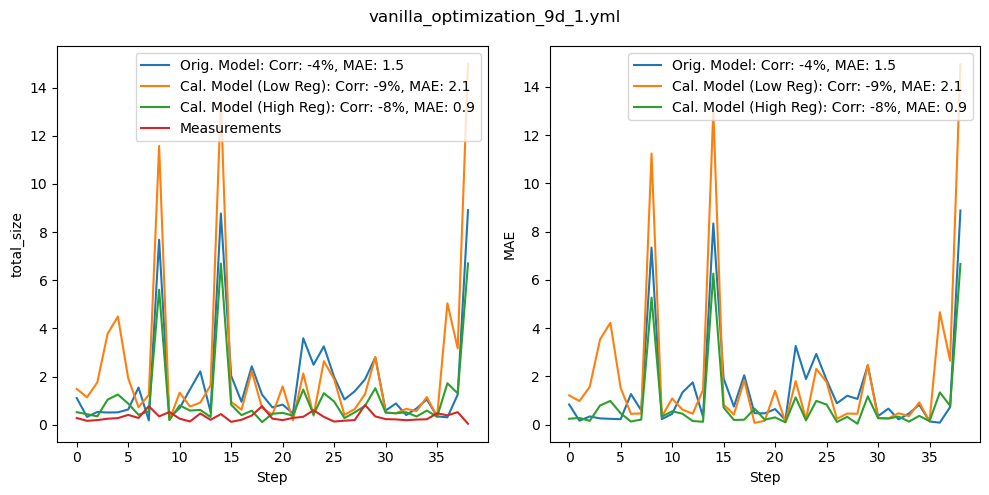

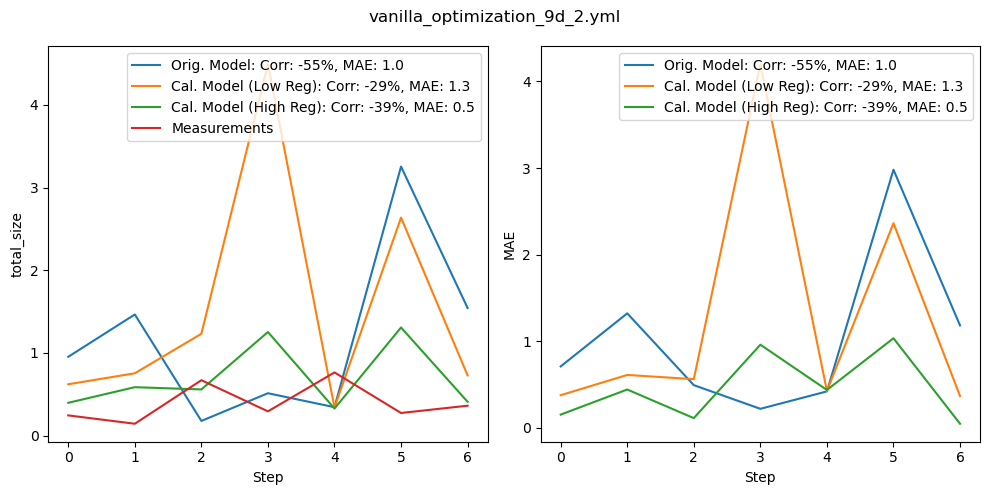

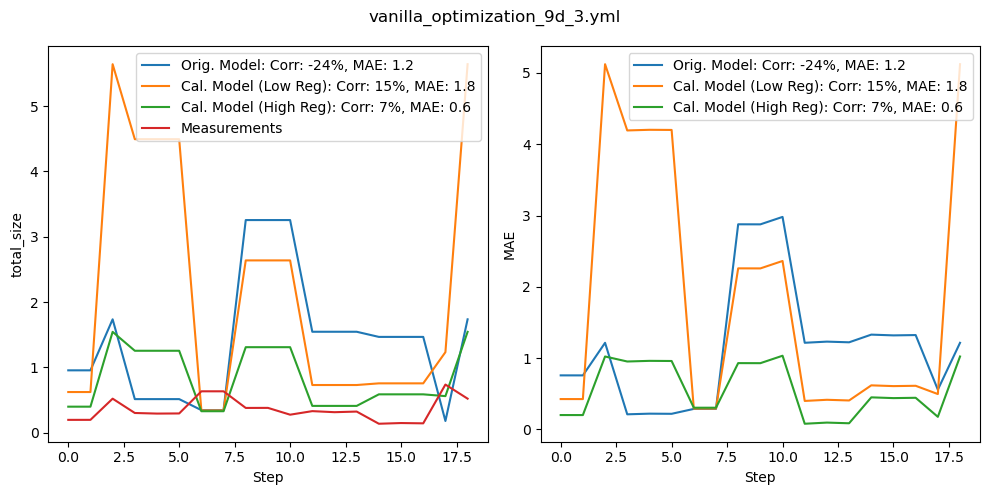

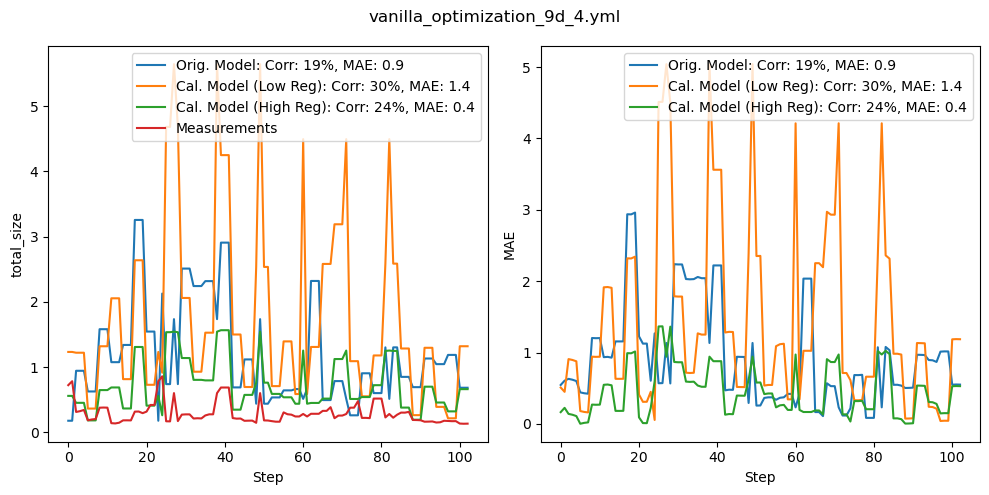

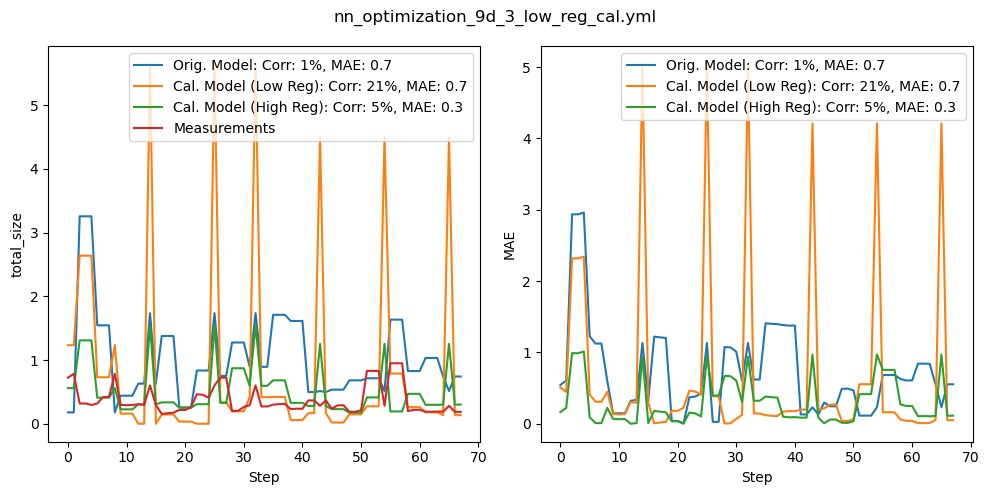

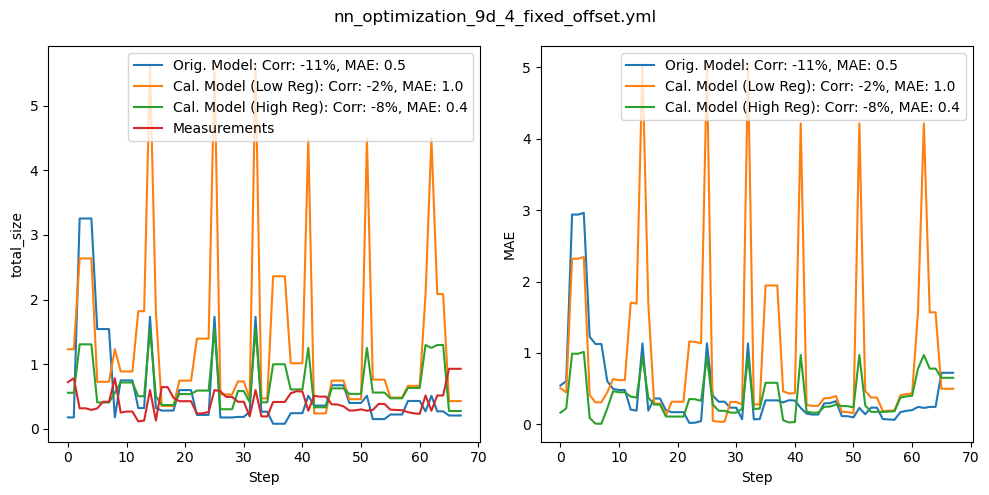

In [13]:
for X, file in zip(xs, files):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    df, vocs = X.data, X.vocs
    df = df[vocs.variable_names + [vocs.objective_names[0]]]
    df = df.dropna()
    
    models = [load_nn_prior(vocs), load_cal_prior(vocs, reg="low"), load_cal_prior(vocs, reg="high")]
    x = torch.from_numpy(df[models[0].model.feature_order].to_numpy())
    y = torch.from_numpy(df[vocs.objective_names[0]].to_numpy())

    predictions, errors = [], []
    correlations, maes = [], []
    for model in models:
        pred = model(x)
        predictions.append(pred)
        errors.append(torch.abs(pred - y))
        correlations.append(calc_corr(pred, y).item())
        maes.append(calc_mae(pred, y).item())

    axis = torch.arange(len(errors[0]))
    labels = ["Orig. Model", "Cal. Model (Low Reg)", "Cal. Model (High Reg)"]
    for j in range(len(labels)):
        ax[0].plot(axis, predictions[j], label="{}: Corr: {:.0f}%, MAE: {:.1f}".format(labels[j], 1e2 * correlations[j], maes[j]))
    ax[0].plot(axis, y, label="Measurements")
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel("total_size")
    ax[0].legend(loc="upper right")

    for j in range(len(labels)):
        ax[1].plot(axis, errors[j], label="{}: Corr: {:.0f}%, MAE: {:.1f}".format(labels[j], 1e2 * correlations[j], maes[j]))
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel("MAE")
    ax[1].legend(loc="upper right")

    fig.suptitle(file)
    fig.tight_layout()

## Display Models

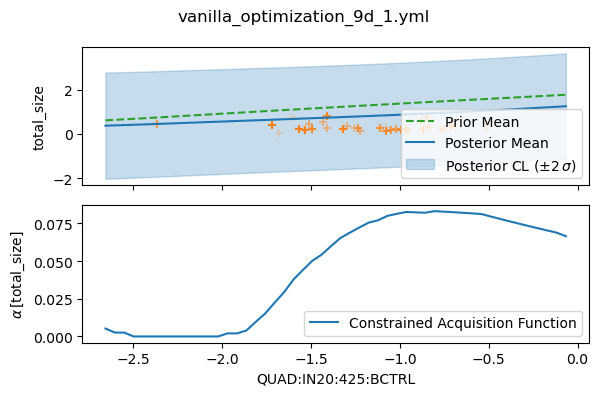

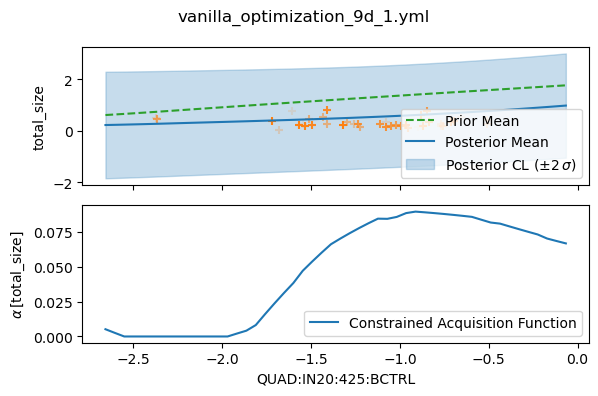

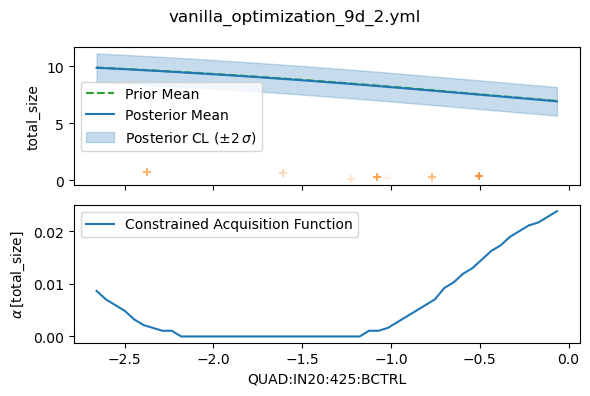

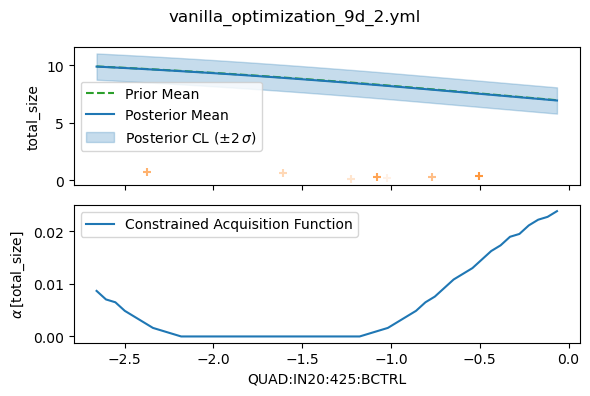

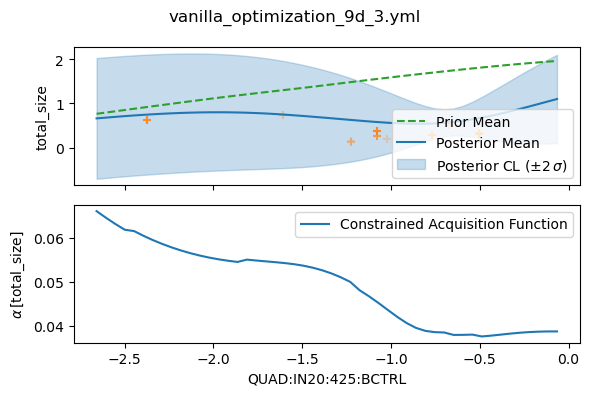

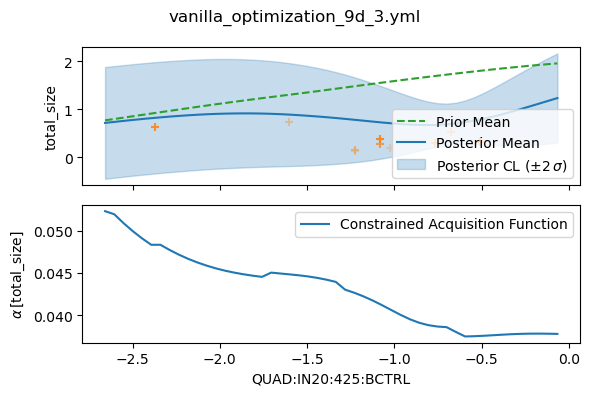

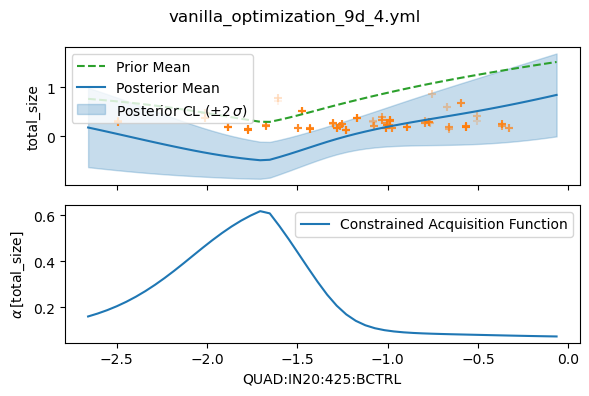

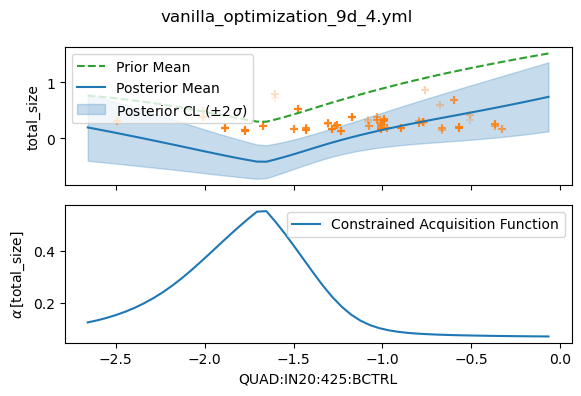

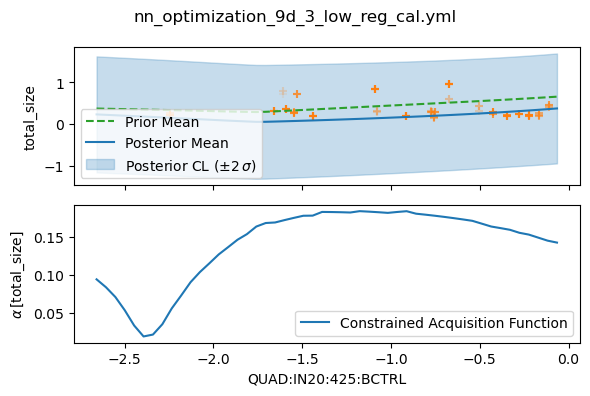

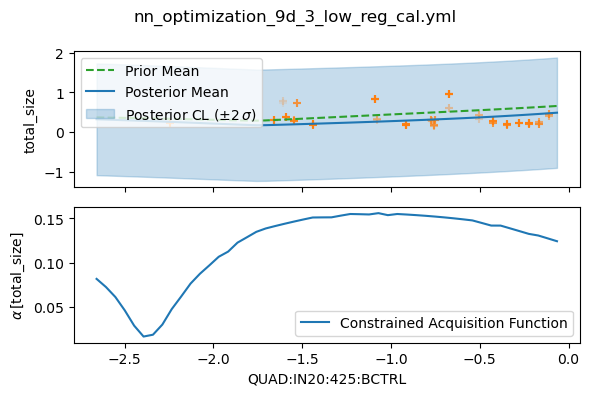

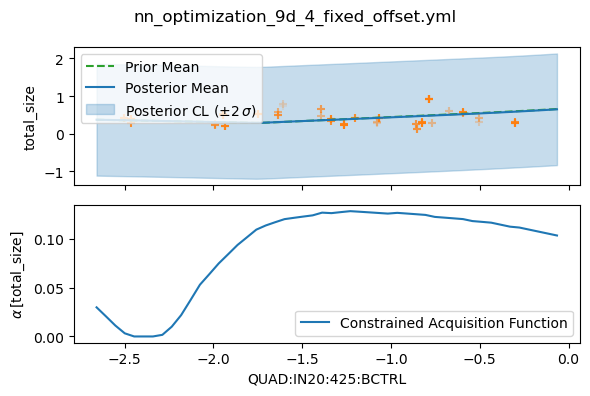

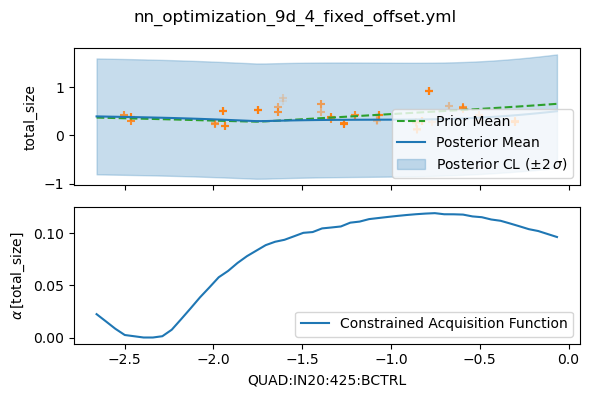

In [21]:
for X, file in zip(xs, files):
    # train models
    _ = X.generator.train_model(X.data)
    fig1, ax1 = display_model(
        X=X,
        # variable_names=["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL"],
        variable_names=["QUAD:IN20:425:BCTRL"],
    )
    fig1.suptitle(file)
    fig1.tight_layout()

    # add prior mean model
    X.generator.model_constructor.mean_modules[X.vocs.objective_names[0]] = load_nn_prior(X.vocs)    
    _ = X.generator.train_model(X.data)
    fig2, ax2 = display_model(
        X=X,
        # variable_names=["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL"],
        variable_names=["QUAD:IN20:425:BCTRL"],
    )
    fig2.suptitle(file)
    fig2.tight_layout()

    plt.show()

## Compare Models for different Prior Means

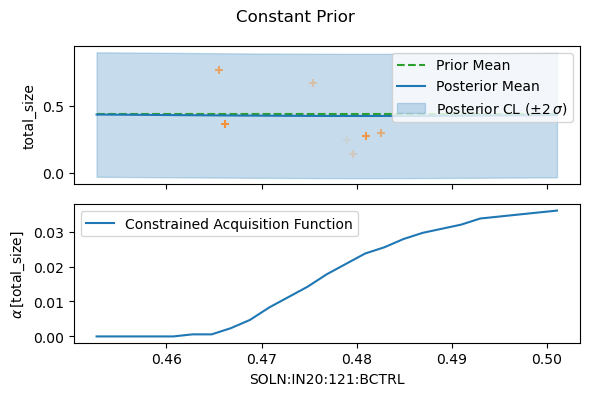

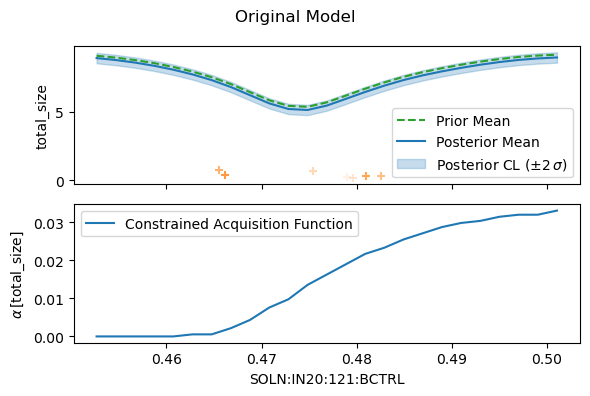

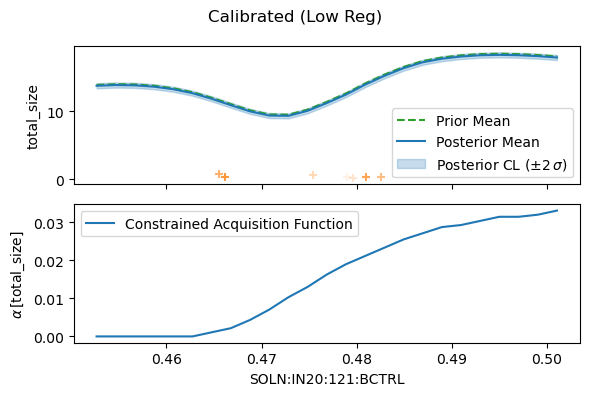

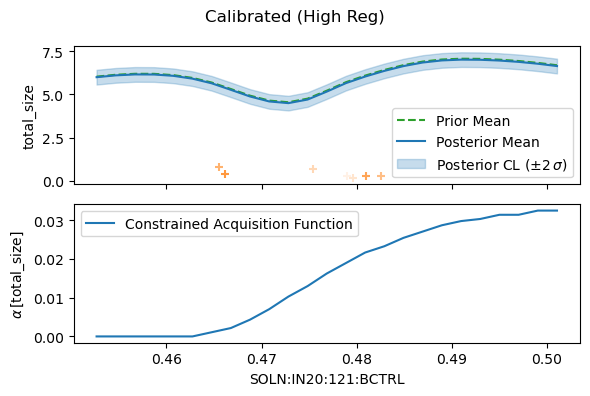

In [19]:
from gpytorch.means import ConstantMean


n_grid = 25
X = xs[1]
# variable_names=["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL"]
variable_names=["SOLN:IN20:121:BCTRL"]

# add prior mean model
X.generator.model_constructor.mean_modules[X.vocs.objective_names[0]] = None
_ = X.generator.train_model(X.data)
fig0, ax0 = display_model(
    X=X,
    variable_names=variable_names,
    n_grid=n_grid,
)
fig0.suptitle("Constant Prior")
fig0.tight_layout()

# add prior mean model
X.generator.model_constructor.mean_modules[X.vocs.objective_names[0]] = load_nn_prior(X.vocs)
_ = X.generator.train_model(X.data)
fig1, ax1 = display_model(
    X=X,
    variable_names=variable_names,
    n_grid=n_grid,
)
fig1.suptitle("Original Model")
fig1.tight_layout()

# add prior mean model
X.generator.model_constructor.mean_modules[X.vocs.objective_names[0]] = load_cal_prior(X.vocs, reg="low")
_ = X.generator.train_model(X.data)

fig2, ax2 = display_model(
    X=X,
    variable_names=variable_names,
    n_grid=n_grid,
)
fig2.suptitle("Calibrated (Low Reg)")
fig2.tight_layout()

# add prior mean model
X.generator.model_constructor.mean_modules[X.vocs.objective_names[0]] = load_cal_prior(X.vocs, reg="high")
_ = X.generator.train_model(X.data)
fig3, ax3 = display_model(
    X=X,
    variable_names=variable_names,
    n_grid=n_grid,
)
fig3.suptitle("Calibrated (High Reg)")
fig3.tight_layout()

## BO Performances

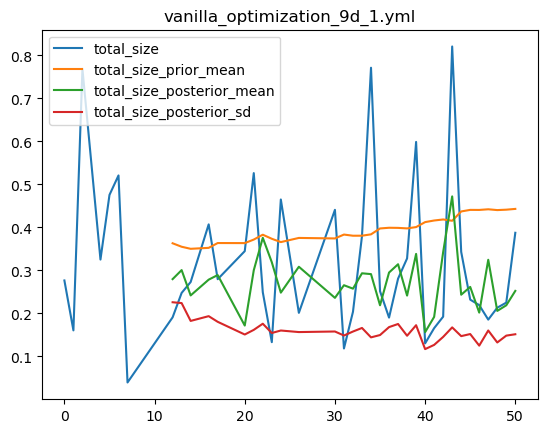

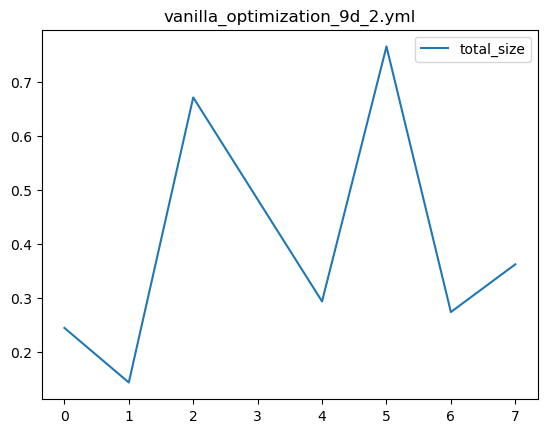

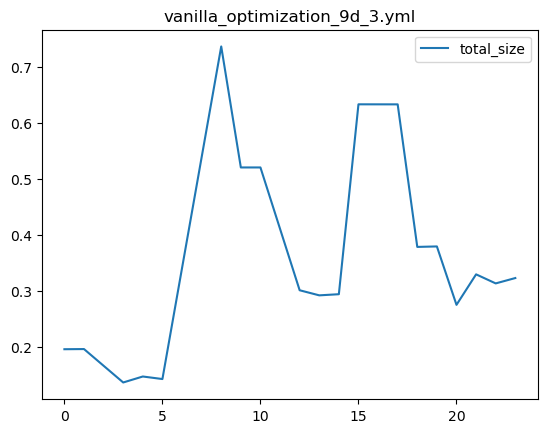

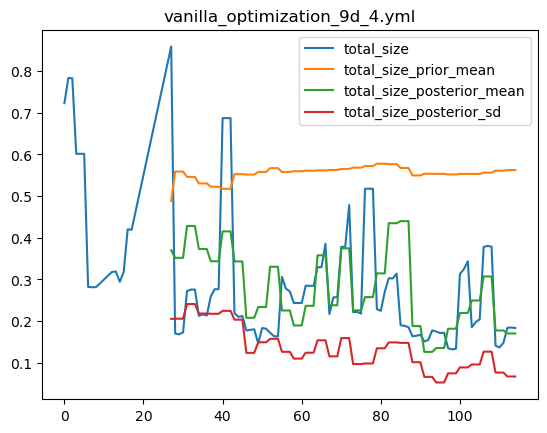

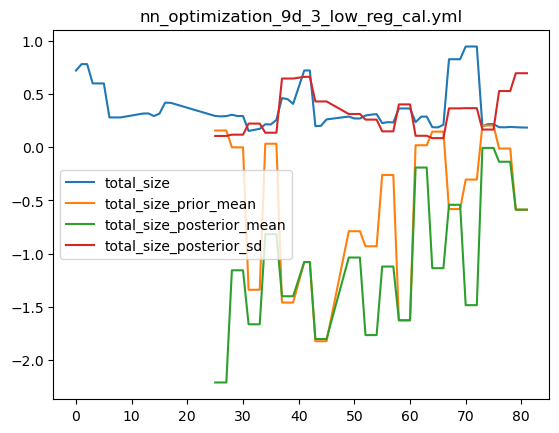

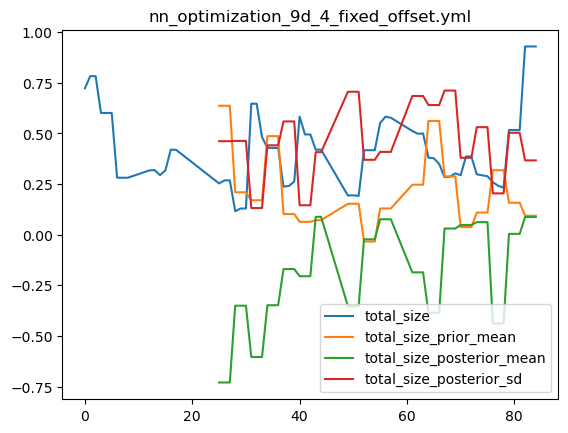

In [16]:
for X, file in zip(xs, files):
    df = X.data
    df.index = df.index.values.astype(int)
    df = df.sort_index()
    df = df.dropna(subset=["total_size"])
    ax = df[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot()
    ax.set_title(file)

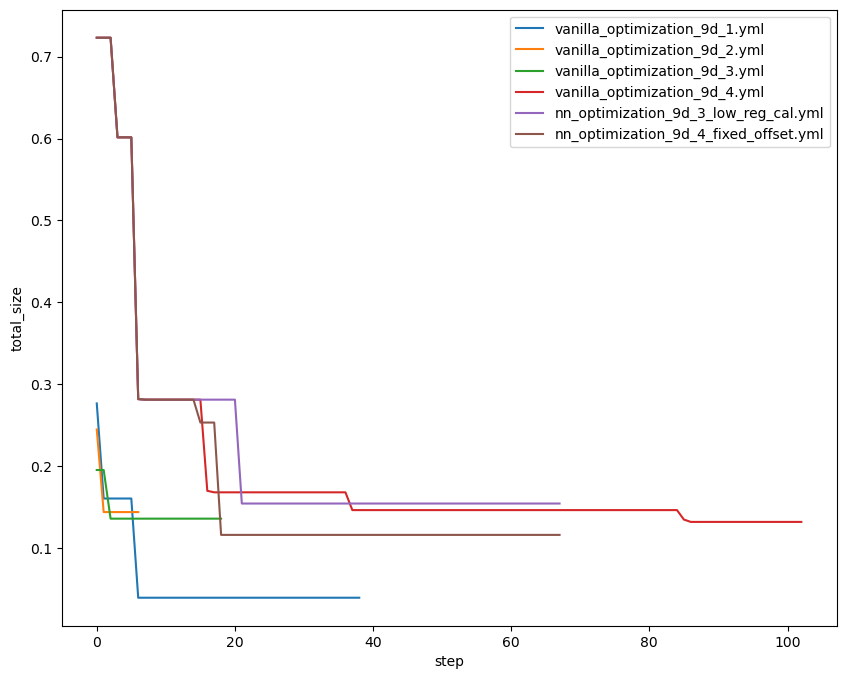

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

for X, file in zip(xs, files):
    df = X.data
    df.index = df.index.values.astype(int)
    df = df.sort_index()
    df = df.dropna(subset=["total_size"])

    # calculate running minimum
    running_min = []
    for i in range(len(df)):
        running_min.append(df[X.vocs.objective_names[0]].iloc[:i+1].min())

    ax.plot(running_min, label=file)
    ax.set_xlabel("step")
    ax.set_ylabel(X.vocs.objective_names[0])
    # ax.set_ylim(130, 200)
    ax.legend()

In [18]:
X = xs[-1]
print(X.vocs.as_yaml())

for k, v in input_variables.items():
    if k in X.vocs.variable_names:
        if X.vocs.variables[k][0] < v.value_range[0] or X.vocs.variables[k][1] > v.value_range[1]:
            print("->", k, v.value_range)
        else:
            print(k, v.value_range)

variables:
  QUAD:IN20:121:BCTRL: [-0.014510000000000002, 0.0022900000000000012]
  QUAD:IN20:122:BCTRL: [-0.016980000000000002, -0.0001799999999999996]
  QUAD:IN20:361:BCTRL: [-4.0449673, -2.7489673]
  QUAD:IN20:371:BCTRL: [2.1482275, 3.4362275]
  QUAD:IN20:425:BCTRL: [-2.6577343, -0.06573429999999991]
  QUAD:IN20:441:BCTRL: [-1.9732700000000003, 1.48273]
  QUAD:IN20:511:BCTRL: [1.7474075, 5.203407500000001]
  QUAD:IN20:525:BCTRL: [-4.3862061, -1.7942061]
  SOLN:IN20:121:BCTRL: [0.4526556, 0.5010555999999999]
constraints:
  bb_penalty: [LESS_THAN, 0.0]
  log10_total_intensity: [GREATER_THAN, 4.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []

-> SOLN:IN20:121:BCTRL [0.3774080152672698, 0.4983800018349345]
QUAD:IN20:121:BCTRL [-0.02098429469554406, 0.020999198106589838]
QUAD:IN20:122:BCTRL [-0.020998830517503037, 0.020998929132148195]
QUAD:IN20:361:BCTRL [-4.318053641915576, -1.0800430432494976]
QUAD:IN20:371:BCTRL [1.0913525514575348, 4.30967984810423]
-> QUAD:IN20:4